In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [33]:
def make_trans_moons(theta=40, nb=100, noise=.05):
    from sklearn.datasets import make_moons
    from math import cos, sin, pi
    
    X, y = make_moons(nb, noise=noise, random_state=1) 
    Xt, yt = make_moons(nb, noise=noise, random_state=2)
    
    trans = -np.mean(X, axis=0) 
    X  = 2*(X+trans)
    Xt = 2*(Xt+trans)
    
    theta = -theta*pi/180
    rotation = np.array( [  [cos(theta), sin(theta)], [-sin(theta), cos(theta)] ] )
    Xt = np.dot(Xt, rotation.T)
    
    return X, y, Xt, yt

In [34]:
X,y,Xt,yt = make_trans_moons()

In [35]:
class moon_model(torch.nn.Module):
    
    def __init__(self):
        super(moon_model, self).__init__()
        self.W = torch.nn.Linear(in_features=2, out_features=15)
        self.V = torch.nn.Linear(in_features=15, out_features=2)
        self.u = torch.nn.Parameter(torch.zeros((15, 1), requires_grad=True))
        self.d = torch.nn.Parameter(torch.zeros((1,1), requires_grad=True))
        self.sigmoid = torch.nn.Sigmoid()
        self.lam = 5
    
    def forward(self, X):
        return self.V(self.sigmoid(self.W(X)))
    
    def domain_adapt(self, X):
        Gf = self.sigmoid(self.W(X))
        Gd = self.sigmoid(torch.matmul(Gf, self.u) + self.d)
        self.d.grad = self.lam * (1-Gd)
        self.u.grad = self.d.grad * Gf.T
#         self.tmp = (self.lam*(1-Gd)*self.u).T * (Gf*(1-Gf))
#         self.W.bias.grad += self.tmp[0]
#         self.W.weight.grad += self.tmp.T * X
    
    def domain_regularize(self, X):
        Gf = self.sigmoid(self.W(X))
        Gd = self.sigmoid(torch.matmul(Gf, self.u) + self.d)
        self.d.grad -= self.lam * (Gd)
        self.u.grad -= self.lam * (Gd) * Gf.T
#         self.tmp = (-1*self.lam*(Gd) * self.u).T*Gf*(1-Gf)
#         self.W.bias.grad += self.tmp[0]
#         self.W.weight.grad += self.tmp.T * X
    

In [36]:
model = moon_model()

In [37]:
softmax_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=0.05, params=model.parameters())

In [71]:
controller = tqdm(range(100))
for epoch in controller:
    for i in range(len(X)):
        
        optimizer.zero_grad()
        sample, target = torch.Tensor(X[i]).unsqueeze(0), torch.Tensor([y[i]]).reshape([1]).long()
        di = np.random.randint(len(Xt))
        dsample, dtarget = torch.Tensor(Xt[di]).unsqueeze(0),torch.Tensor([yt[di]]).reshape([1]).long()

        loss = softmax_loss(target=target, input=model(sample))
        loss.backward()
        
        model.domain_adapt(sample)
        model.domain_regularize(dsample)
        model.u.grad *= -1
        model.d.grad *= -1
        optimizer.step()
        
        controller.set_postfix({"loss":loss.item()})

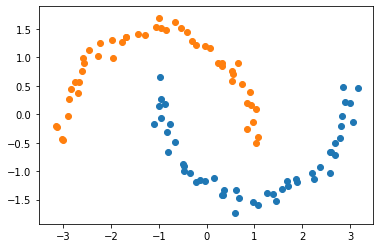

In [72]:
plt.scatter(X[model(torch.Tensor(X)).argmax(1)==1][:,0], X[model(torch.Tensor(X)).argmax(1)==1][:,1])
plt.scatter(X[model(torch.Tensor(X)).argmax(1)==0][:,0], X[model(torch.Tensor(X)).argmax(1)==0][:,1])

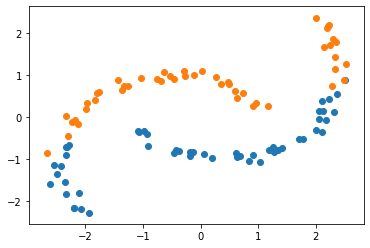

In [117]:
plt.scatter(Xt[model(torch.Tensor(Xt)).argmax(1)==1][:,0], Xt[model(torch.Tensor(Xt)).argmax(1)==1][:,1])
plt.scatter(Xt[model(torch.Tensor(Xt)).argmax(1)==0][:,0], Xt[model(torch.Tensor(Xt)).argmax(1)==0][:,1])

In [74]:
from sklearn.decomposition import PCA

In [75]:
pca = PCA(n_components=2)

In [76]:
first_output = model.sigmoid(model.W(torch.Tensor(X))).detach().cpu().numpy()
second_output = model.sigmoid(model.W(torch.Tensor(Xt))).detach().cpu().numpy()

In [77]:
output = pca.fit_transform(np.concatenate([first_output, second_output]))

In [78]:
index = np.arange(len(output))

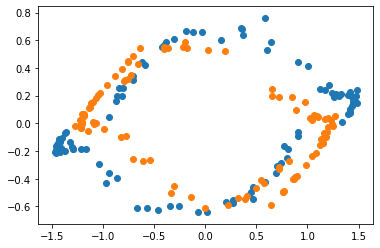

In [79]:
plt.scatter(output[index<100][:, 0], output[index<100][:, 1] )
plt.scatter(output[index>=100][:, 0], output[index>=100][:, 1] )

In [113]:
def decision_boundary(X):
    from scipy.interpolate import interp1d
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    inputs = np.c_[xx.ravel(), yy.ravel()]
    
    for k in range(15):
        Gf = model.sigmoid(model.W(torch.Tensor(inputs))).detach().numpy().round(1) == 0.5
        
        interp = interp1d(inputs[Gf[:, k]][:, 0], inputs[Gf[:, k]][:, 1])
#         print(interp.shape)
        xnew_min, xnew_max = inputs[Gf[:, k]][:, 0].min(), inputs[Gf[:, k]][:, 0].max()
        xnew = np.linspace(xnew_min, xnew_max, 2)
        plt.plot(xnew, interp(xnew))
#         Gf = ()[:, k]
#         Z = Gf.detach().numpy().reshape(xx.shape)
#         plt.imshow(Z)
#         plt.show()
#     plt.contourf(xx, yy, Z, alpha=0.4)

In [ ]:
decision_boundary(X)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label="Source-1")
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label="Source-0")
plt.scatter(Xt[:, 0], Xt[:, 1], label="Target")
plt.legend()

In [119]:
np.count_nonzero(model(torch.Tensor(X)).argmax(1).cpu().numpy() == y)/len(y)

1.0